# WIP: Notebook about storing and exploring gridded data with xarray and holoviews

related issues: 
[holoviews](https://github.com/ioam/holoviews/issues/2341#issuecomment-365925725)
[xarray](https://github.com/pydata/xarray/issues/1914)


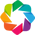

In [1]:
import itertools as it

import xarray as xr
import pandas as pd
import numpy as np

import holoviews as hv
hv.notebook_extension('bokeh', 'matplotlib')

# Define example problem

In [2]:
def energies(k, A, B, M, V):
    m = np.array([[A * k**2 + M + V, B * k], 
                  [B * k, A * k**2 - M + V]])
    ev = np.linalg.eigvalsh(m)
    return ev


coordinates = {
    'k': np.linspace(-.5, .5, 101),
    'A': range(1, 5),
    'B': np.linspace(0, 1, 5),
    'M': np.linspace(0, .1, 5),
    
}

constants = {
    'V': 0.5
}


inps = [{**constants, **{k: v for k, v in zip(coordinates.keys(), x)}} 
        for x in list(it.product(*coordinates.values()))]

# First try

In [3]:
%%time

def compute(**kwargs):
    e = energies(**kwargs)
    return xr.DataArray(e, coords={'n': range(2), **kwargs}, 
                        dims='n', name='bands')

values = list(map(lambda s: compute(**s), inps))

CPU times: user 2.28 s, sys: 10.9 ms, total: 2.29 s
Wall time: 2.34 s


In [4]:
%%time
ds = xr.concat(values, dim='new', coords='all')
ds = ds.set_index(new=list(set(ds.coords) - set(ds.dims)))
ds = ds.unstack('new')

CPU times: user 4.3 s, sys: 9.28 ms, total: 4.3 s
Wall time: 4.3 s


In [5]:
hv_ds = hv.Dataset(ds)
curves = hv_ds.to(hv.Curve, 'k', 'bands').overlay('n')

In [6]:
%%output max_frames=900
curves

:HoloMap   [M,V,B,A]
   :NdOverlay   [n]
      :Curve   [k]   (bands)

# xarray coords 

In [7]:
import xarray as xr
import numpy as np
ds = xr.Dataset(coords={'x': np.linspace(-1, 1), 'y': np.linspace(0, 10), 'a': 1, 'b': [1, 2, 3]})

In [8]:
coords = {**coordinates, **constants}
coords = xr.Dataset(coords=coords)

In [9]:
coords.stack(iteration=coords.dims)

<xarray.Dataset>
Dimensions:    (iteration: 10100)
Coordinates:
    V          float64 0.5
  * iteration  (iteration) MultiIndex
  - A          (iteration) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - B          (iteration) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  - M          (iteration) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  - k          (iteration) float64 -0.5 -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 ...
Data variables:
    *empty*

# example with numpy: what actualy we'd like to do

In [10]:
data = np.zeros((10, 5, 10))

for (i, j, k), _ in np.ndenumerate(data):
    data[i, j, k] = i + j + k

In [11]:
data

array([[[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
        [  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
        [  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.],
        [  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.],
        [  4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.]],

       [[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.],
        [  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.],
        [  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.],
        [  4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.],
        [  5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.]],

       [[  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.],
        [  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.],
        [  4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.],
        [  5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.],
        [  6.,  